# Estimating values

__This is in draft. The methods are correct but the narrative, descriptions and references are being defined. The language needs to be standardized to english, there are several data sources in multiple languages (this is Switzerland)__

The data gathered by the SWE team in 2020 was included in the federal report on shoreline litter density. Since the puplication of IQAASL in December 2021 there has been addtional data collection events on Lac Léman

1. SWE team
2. Association for the Sauvegarde du Léman completed 100 beach litter surveys in 2022

__Six year sampling period__

The timing of these samples, seven years after the first samples were recorded, could be interpreted as the begining of a new six year sampling period that started in January 2022. The Joint Research Center (JRC) at the EU suggest a six year sampling period with preferably ~ 40 surveys in that time, for each beach that is being monitored. If these conditions are met a baseline value can be established for the location in question. The baseline value, using this method is the median value of the surveys for the time period.

There are over 250 samples in the initial six year period, from 30+ locations on the lake. There are no locations that have 40 surveys, therefore the method described previously would not be appropriate for any single location, but it is more than enough for the lake. Recall that we previously discussed the following:

1. independence of samples: difference among sampling groups
2. land use: correlation of survey results to topographic features

## Research questions

__For the lake and Saint Sulpice:__

1. Given the data from 2022, Is there an increase, decrease or no change in the expected survey results given the consolidated results from 2015 - 2021?
2. Is the mix of identified objects different between 2022 and 2015 - 2021?
3. Given the median value for the objects of interest in 2021, what is the chance that a survey in 2022 will exceed this value?
4. How do the results from 2022 change the expected survey results going forward?

### Practical applications

Investments have been made to either prevent or remove litter from the public space. The investments are made with the intention of reducing litter in the environment. The answers to the research questions should help evaluate the return on investment (ROI) from previous projects and provide insights for projects going forward. 

1. __Did the investment result in a net decline in litter?__
2. __What objects were particularly effected?__
3. __How does the municpality compare to the rest of the lake?__

The prior investments were part of a regional action plan that included all municipal and cantonal administrations on the lake. Therefore, municipal results need to be formulated in the context of the canton and the lake.

## Methods and definitions

### threshold

The threshold of interest is the median survey result for an object given the data from 2015 - 2021 

### frequency

The frequency of exceeding a threshold is the number of times that a threshold was exceeded (k) divided by the number of samples taken (n) or k/n.

### land-use

The common topographical features within a radius of 1500m from each survey location. 

### probability

The probability of exceeding the threshhold is conditioned upon when the survey was taken, where the survey is located and the land-use. Recall that k/n can be interpreted as the likelihood (MLE) of the binomial distribution that the threshhold will be exceeded. This ratio, along with the observed k and n of a particular location or group of locations can be combined using a common rule of probability:

$$p(a|b) = \frac{p(b|a)*p(a)}{p(b)}$$

Substituting the variables from the data:

$$p(threshhold|landuse) = \frac{p(landuse|threshhold)*p(threshhold)}{p(landuse)}$$

* $p(threshhold|landuse)$ = __Posterior:__ the probability of exceeding the threshhold given the land use conditions, the question we are trying to answer
* $p(landuse|threshhold)$ = __The likelihood__ of exceeding the threshhold for a land-use attribute given $threshold$. The n/k for a location from the sampling period of interest. This does not include results from other locations .
* $p(threshhold)$ = The __prior__ knowledge. The n/k of all locations with similar landuse conditions to the location of interest.
* $p(landuse)$ = __The total probability__, the probability under all possible land-use conditions and all possible thresholds

This is read as:

> The probability of exceeding the threshold given the land-use conditions is equal to the product of  the probability that the threshold was exceeded for a land-use condition given the proabability of exceeding the threshold _times_ the probability of exceeding the threshhold, _divided_ by the probability of exceeding the threshold under all land-use condtions and all thresholds. ([Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem)) ([conditional proabability](https://en.wikipedia.org/wiki/Conditional_probability))


### Inference tables

Point estimates can be calculated using the formula above. This example is 100% inspired by Alan Downeys example in [Think Bayes 2](https://allendowney.github.io/ThinkBayes2/chap02.html). There are two separate hypothesis: _h = the threshhold was exceeded_, _h1 = the threshhold was not exceeded_. Total probability is accounted for when the column _likelihood*prior_ is added up and divided through to make the _posterior_ column. 

In [1]:
# sys, file and nav packages:
%load_ext watermark
import os
import datetime as dt


# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt 
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import percentileofscore

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import seaborn as sns
import matplotlib.gridspec as gridspec

# home brew utitilties
import resources.sr_ut as sut
import resources.featuredata as fd
# import resources.chart_kwargs as ck

# documenting
from IPython.display import display, HTML
from IPython.display import Markdown as md

# all the data
adata = pd.read_csv("resources/start_data.csv")

dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfBeaches = dfBeaches[dfBeaches.slug != "clean-up-event-test"]
dfBeaches.set_index("slug", inplace=True)

# dfBeaches = dfBeaches.set_index("slug", drop=True)
wt_map = dfBeaches.water
ct_map = dfBeaches.city
wn_map = dfBeaches.water_name
rb_map =dfBeaches.river_bassin

# all_data = adata.copy()
all_data = adata[adata.river_bassin != 'les-alpes'].copy()
# print(all_data.columns)
columns_i = [
    'loc_date',
    'location',
    'date', 
    'water_name_slug',
    'river_bassin',
    'city',
    'code', 
    'quantity',
    'pcs_m', 
]

all_data["date"] = pd.to_datetime(all_data["date"], format="%Y-%m-%d")

all_data["doy"] = all_data["date"].dt.dayofyear
all_data["date"] = all_data["date"].dt.date

columns_i = [
    'loc_date',
    'location',
    'date',
    'doy',
    'water_name_slug',
    'water',
    'river_bassin',
    'city',
    'code', 
    'quantity',
    'pcs_m', 
]

all_data["water"]= all_data.location.apply(lambda x: wt_map.loc[x])

gfoam = ["G81", "G82", "G83"]
plasticpcs = [ "G78", "G79", "G80", "G75", "G76", "G77"]
Gcaps = [ "G21", "G23", "G24" ]

# the columns that are being kept and the operations per column          
# columns = ['loc_date', 'location', 'city', 'date', 'length', "doy"]
operations = {"quantity":"sum", "pcs_m":"sum"}

# separate the codes of interest by group from the data frame and add the replacement value
all_data_gfrags = all_data[all_data.code.isin(plasticpcs)].groupby(columns_i[:-2], as_index=False).agg(operations)
all_data_gfoam = all_data[all_data.code.isin(gfoam)].groupby(columns_i[:-2], as_index=False).agg(operations)
all_data_gcaps = all_data[all_data.code.isin(Gcaps)].groupby(columns_i[:-2], as_index=False).agg(operations)

all_data_gcaps["code"] = "Gcaps"
all_data_gfoam["code"] = "Gfoam"
all_data_gfrags["code"] = "Gfrags"

# remove the same instances from the work data                                                               
all_data_no_frags = all_data[columns_i][~all_data.code.isin([*plasticpcs, *gfoam, *Gcaps])].copy()

# formatted plastock data
all_data = pd.concat([all_data_no_frags, all_data_gfrags, all_data_gfoam, all_data_gcaps])

all_data = all_data.groupby(columns_i[:-2], as_index=False).agg(operations)
all_data = all_data[~all_data.location.isin(['schiffenensee_duedingen_hirschij', 'sihlsee_einsiedeln_schilligerllacherl', 'lac-leman-hammerdirt'])]

# map to code decriptions
dfCodes.set_index("code", inplace=True)
dfCodes.loc["Gcaps", ["material", "description", "groupname"]] = ["Plastic", "Plastic bottle lids", "food and drink"]
code_d = dfCodes["description"]

# map to material descriptions
mat_d = dfCodes["material"]

# leman and st sulpice data
coi = "Saint-Sulpice (VD)"

boi = ["plage-de-st-sulpice","parc-des-pierrettes"]

def make_date_object(astring):
    fmat = "%Y-%m-%d"

    an_obj = dt.datetime.strptime(astring, fmat).date()   

    return an_obj


In [2]:
def make_masks(use, bins, data):
    # a mask for the survey results
    # constrains the data to the use
    # and the bin numbers defined by the parameters
    # returns two boolean series

    mask = (data.use == use) & (data.binned.isin(bins))

    return mask


def retrieve_similar_locations(mask, data):
    # applies a mask that selects locations based on bin number and use
    # returns a list of locations. The locations all share the same 
    # bin number for an attribute.
    masked = data[mask].index
    
    return masked

def retrieve_k_and_n(masked, sresults, threshold: float = 0, rate="pcs_m", magnitude: bool = False):
    # constrains the results to the locations in masked
    # indentifies the survey results that are equal to or
    # exceed the threshold. Counts the number of unique samples
    # returns a tuple of integers

    d = sresults[sresults.location.isin(masked)] 

    if magnitude:
        k = d[rate]
    else:
        k = (d[rate] >= threshold).sum()
        
    n = d["loc_date"].nunique()    
        
    return k, n



def results_and_land_use(all_data, land_use_agg, slr_e, prior_locations, codes):
    # the survey results from all the data prior to the date defined by slr_e
    # and from locations on lakes. Includes only the codes of interest
    # returns two dataframes
    p_results = all_data[(all_data.date <= slr_e)&(all_data.water == "l")]
    p_results = p_results[p_results.code.isin(codes)]

    # the landuse values for all the locations in p_results
    p_ludata = land_use_agg.loc[prior_locations]
    

    return p_results, p_ludata

def prior_k_n_for_a_period(masked, p_results, tholds, cois, uses, magnitude: bool = False):
    res = []
    for i,amask in enumerate(masked):
        if magnitude:
            ksandns = [retrieve_k_and_n(amask, p_results[p_results.code == x], threshold=tholds.loc[x], magnitude=magnitude) for x in cois]
            k_and_ns = {x:ksandns[j] for j, x in enumerate(cois)}
            res.append(k_and_ns)
        else:
            ksandns = [retrieve_k_and_n(amask, p_results[p_results.code == x], threshold=tholds.loc[x]) for x in cois]
            k_and_ns = {x:ksandns[j] for j, x in enumerate(cois)}
            res.append(k_and_ns)
    
    
    if magnitude:
        tprior = res
    else:
        tprior = pd.DataFrame(res, index=uses)
    
    return tprior

def k_over_n_for_prior_k_n(tprior):
    tp = tprior.apply(lambda col: [sum(x) for x in zip(*col)], axis=0)
    tp = tp.loc[0]/tp.loc[1]

    return tp

In [3]:
# these are the land use values for each hex
# nutuzungsareal and freizeit areal are totaled
# the surface area of these two use cases gets added
# to the total of the land cover surface area
dfln = pd.read_csv("resources/geodata/infrastructure.csv")
dflf = pd.read_csv("resources/geodata/recreation.csv")
locations = all_data.location.unique()

# rename the columns and total the surface are for each component
dflf.rename(columns={"OBJEKTART":"use"}, inplace=True)
dflf = dflf[~dflf.use.isin(['Reben', 'Obstanlage'])].copy()
dflf_t = dflf.groupby(["slug", "city", "water_name", "water"], as_index=False).area.sum()
dflf_t["use"] = "recreation"
dflf_t["scaled"] = (dflf_t["area"] - dflf_t["area"].min())/(dflf_t["area"].max() - dflf_t["area"].min())

dfln.rename(columns={"OBJEKTART":"use"}, inplace=True)
dfln = dfln[~dfln.use.isin(['Reben', 'Obstanlage'])].copy()
dfln_t = dfln.groupby(["slug", "city", "water_name", "water"], as_index=False).area.sum()
dfln_t["use"] = "infrastructure"
dfln_t["scaled"] = (dfln_t["area"] - dfln_t["area"].min())/(dfln_t["area"].max() - dfln_t["area"].min())

rec_inf = pd.concat([dfln_t, dflf_t])
rec_inf = rec_inf[rec_inf.slug.isin(locations)]
rec_inf.rename(columns={"area":"magnitude"}, inplace=True)

dflc = pd.read_csv("resources/geodata/landcover.csv")
dflc = dflc[dflc.slug.isin(locations)].copy()

# sum the unique land cover values for each location
area_of_a_hex = 5845672
xgr = dflc.groupby(["slug", "city", "water_name", "OBJVAL", "water"], as_index=False, dropna=False).area.sum()

# the sum of all the land cover values for a location
xgrt = xgr.groupby(["slug", "city", "water_name", "water"], as_index=False).area.sum()

# the amount of surface area that is not accounted for 
xgrt["undefined"] = area_of_a_hex - xgrt.area

# format data frame to join to the other land cover totals
xgrt["OBJVAL"] = "undefined"
xgrt["area"] = xgrt["undefined"]
xgrt.drop("undefined", inplace=True, axis=1)

# add to other totals
dflcx = pd.concat([xgr, xgrt])


# remove the value of See from the surface area of a hex.
# We are considering the magnitude of land use type in relation
# to the amount of land that is available to be used, not including 
# amount of land that is covered by the lake itself
# xsee = xgr[xgr.OBJVAL == "See"][["slug", "area"]]
# xsee["hex minus"] = area_of_a_hex - xsee.area
# hex_minus = xsee[["slug", "hex minus"]].set_index("slug", drop=True)
xgr_l = xgr[xgr.water == "l"].copy()
xgr_r = xgr[xgr.water == "r"].copy()
xgr_r["hex minus"] = area_of_a_hex

xsee = xgr_l[xgr_l.OBJVAL == "See"][["slug", "area"]]
xsee["hex minus"] = area_of_a_hex - xsee.area
hex_minus = xsee[["slug", "hex minus"]].set_index("slug", drop=True)


hex_not_minus = xgr_r[["slug", "hex minus"]].drop_duplicates("slug").set_index("slug", drop=True)
# hex_not_minus.drop_duplicates(inplace=True)
xsee_all = pd.concat([hex_not_minus, hex_minus])

# map the adjusted surface area to to the land use
# totals and scale the surface column to the adjusted surface area
dflcx["hex minus"] = dflcx.slug.apply(lambda x: xsee_all.loc[x, "hex minus"])
# rec_inf["hex minus"] = rec_inf.slug.apply(lambda x: xsee_all.loc[x, "hex minus"])
# change column name
dflcx.rename(columns={"OBJVAL":"use"}, inplace=True)

land_cover = dflcx.copy()

land_cover["scaled"] = land_cover.area/land_cover["hex minus"]

# remove See from the data frame
land_cover = land_cover[land_cover.use != "See"]

bind = pd.IntervalIndex.from_tuples([(-1, 0), (0.0000001, .0499999), (.0500000, .0999999), (.1000000, .1499999),(.1500000, .1999999), (.2, .2499), (.25, .2999), (.3000, .3499),
        (.35, .3999), (.4000, .449999), (.45, .499999),(.5, .549999), (.55, .5999), (.6000, .6499), (.65, .6999), (.7, .7499), (.75, .7999),
        (.8, .8499), (.85, .8999), (.9, .9499), (.95, 1)])

# bin the scaled column
sbins = pd.cut(land_cover.scaled, bins=bind, labels=np.arange(start=0, stop=21), include_lowest=True, retbins=False)
sbins=sbins.cat.rename_categories(np.arange(start=0, stop=21))

rbins = pd.cut(rec_inf.scaled, bins=bind, labels=np.arange(start=0, stop=21), include_lowest=True, retbins=False)
rbins=rbins.cat.rename_categories(np.arange(start=0, stop=21))
rec_inf["binned"] = rbins

merge_columns = ["slug", "city", "water_name", "water", "magnitude", "use", "scaled", "binned"]
land_cover["binned"] = sbins
land_cover.rename(columns={"area":"magnitude"}, inplace=True)
merge_df = land_cover[merge_columns]
agg_land_use = pd.concat([rec_inf, merge_df])

dist_ct = pd.read_csv("resources/geodata/intersect_length.csv")
dist_ct = dist_ct.groupby(["slug","city", "water_name", "water", "NAMN"], as_index=False).length.sum()
dist_ct[dist_ct.slug == "mullermatte"]

dist_dt = pd.read_csv("resources/geodata/d_to_intersect.csv")

dist_dt["water"] = dist_dt.slug.apply(lambda x: wt_map.loc[x])
dist_dt["city"] = dist_dt.slug.apply(lambda x: ct_map.loc[x])
dist_dt["water_name"] = dist_dt.slug.apply(lambda x: wn_map.loc[x])
# dist_dt = dist_ct.groupby("location", as_index=False).agg({"distance":"mean", "length":"sum"})
# dist_dt = dist_dt[dist_dt.location.isin(df.location.unique())].copy()
# dist_dt = pd.melt(dist_dt, id_vars = "location", value_vars=["length", "distance"])
dist_dt = dist_dt.groupby(["slug", "NAMN", "water", "city", "water_name"], as_index=False).dist.sum()
dr = dist_dt[dist_dt.water == "r"].copy()
dr["dist"] = 0
dnr = dist_dt[dist_dt.water != "r"].copy()
dist_dt = pd.concat([dnr, dr])
dist_dt = pd.melt(dist_dt, id_vars = ["slug", "NAMN", "water", "city", "water_name"], value_vars=["dist"])
dist_ct = pd.melt(dist_ct, id_vars = ["slug", "NAMN", "water", "city", "water_name"], value_vars=["length"])

# river network and disttance to intersection
dist_it_len = pd.concat([dist_dt, dist_ct])

# min max scale
dist_it_len["scaled"] = (dist_it_len["value"] - dist_it_len["value"].min())/(dist_it_len["value"].max() - dist_it_len["value"].min())
# bin in groups of 0.05 plus one bin for zero
sbinsr = pd.cut(dist_it_len.scaled, bins=bind, labels=np.arange(start=0, stop=21), include_lowest=True, retbins=False)
sbinsr=sbinsr.cat.rename_categories(np.arange(start=0, stop=21))
dist_it_len["binned"] = sbinsr
dist_it_len.rename(columns={"variable":"use", "value":"magnitude"}, inplace=True)
dist_it_len.set_index("slug", inplace=True, drop=True)

strasse = pd.read_csv("resources/geodata/streets.csv", low_memory=False)
strasse = strasse[strasse.slug.isin(locations)].copy()
strasse.fillna(0, inplace=True)
stras = strasse.groupby(["slug", "water_name", "city", "water"], as_index=False)["street len"].sum()

# min max scale
stras["scaled"] = (stras["street len"] - stras["street len"].min())/(stras["street len"].max() - stras["street len"].min())
sbinsras = pd.cut(stras.scaled, bins=bind, labels=np.arange(start=0, stop=21), include_lowest=True, retbins=False)
sbinsras=sbinsras.cat.rename_categories(np.arange(start=0, stop=21))
stras["binned"] = sbinsras
stras["use"] = "Strasse"
stras.rename(columns={"street len":"magnitude"}, inplace=True)

land_use_agg = pd.concat([stras, agg_land_use])
land_use_agg.fillna(0, inplace=True)
land_use_agg.set_index("slug", drop=True, inplace=True)
collection_points = dfBeaches[dfBeaches.water == "l"].water_name_slug.unique()

### local environmental conditions

_define land use attributes_

#### distribution of landuse attributes

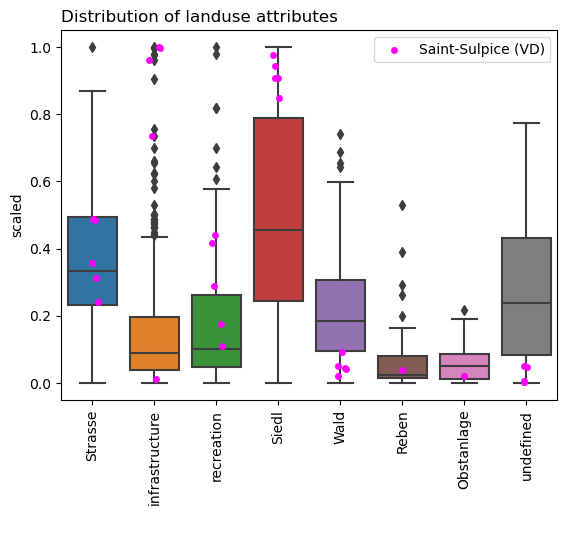

In [4]:
st_sulpice = land_use_agg.loc[(land_use_agg.city==coi)]
sp = st_sulpice[["magnitude", "scaled", "binned", "use"]]
uses = sp.use.unique()
fig, ax = plt.subplots()
sns.boxplot(data=land_use_agg[land_use_agg.use.isin(uses)], x="use", y="scaled", ax=ax)
sns.stripplot(data=sp, x="use", y="scaled", ax=ax, color="magenta", label=coi)
ax.set_title("Distribution of landuse attributes", loc="left")
ax.tick_params(axis='x', labelrotation = 90)
ax.set_xlabel(" ")
h, l = ax.get_legend_handles_labels()
ax.legend([h[0]], [l[0]])
plt.show()

#### correlation of land use attributes

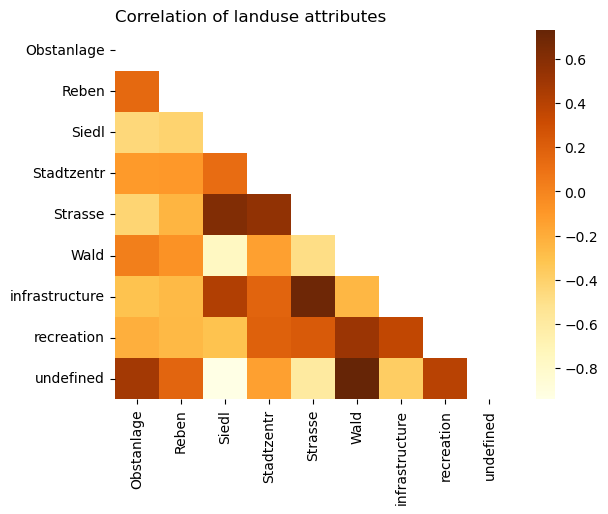

In [5]:
location = boi[1]
code = "G27"
threshold = .47
water_name = wn_map.loc[location]
city = ct_map.loc[location]

tcols = ["binned", "scaled", "magnitude", "use"]
tst = land_use_agg[[*tcols, "water_name"]]
tst = tst[tst.water_name == water_name]
tst = tst[~tst.use.isin(["Geroell", "Stausee"])]
tstx = tst.pivot(columns="use", values="scaled").fillna(0)

corr = tstx.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots()

sns.heatmap(corr, mask=mask, cmap="YlOrBr", ax=ax)

ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Correlation of landuse attributes", loc="left")
plt.show()

### Codes of interest

_define/explain process_

In [6]:
cois = [
    'Gfrags', 'G30', 'G27', 'Gfoam', 'G95', 'Gcaps', 'G67', 'G35', 'G89',
    'G31', 'G32', 'G100', 'G33', 'G25', 'G70', 'G10'
]

# this defines the css rules for the note-book table displays
header_row = {'selector': 'th:nth-child(1)', 'props': f'background-color: #FFF; text-align:right'}
even_rows = {"selector": 'tr:nth-child(even)', 'props': f'background-color: rgba(139, 69, 19, 0.08);'}
odd_rows = {'selector': 'tr:nth-child(odd)', 'props': 'background: #FFF;'}
table_font = {'selector': 'tr', 'props': 'font-size: 12px;'}
table_data = {'selector': 'td', 'props': 'padding: 6px;'}
table_caption = {'selector': 'caption', 'props': 'font-size: 14px; font-style: italic; caption-side: bottom; text-align: left; margin-top: 10px'}
table_css_styles = [even_rows, odd_rows, table_font, header_row, table_caption]

# thresholds
thold_data = all_data[(all_data.date >= make_date_object("2020-04-01"))&(all_data.date <= make_date_object("2021-05-01"))]
thold_data = thold_data[thold_data.water_name_slug == "lac-leman"]
thold_data = thold_data[thold_data.code.isin(cois)]
thold_data = thold_data.groupby(["loc_date", "code"], as_index=False).pcs_m.sum()
tholds = thold_data.groupby(["code"]).pcs_m.median()
tholds_r = (tholds * 100).round()
thold_data["object"] = thold_data.code.apply(lambda x: code_d.loc[x])
tholdsx = thold_data.groupby(["code", "object"], as_index=False).pcs_m.median()
tholdsx.rename(columns={"pcs_m":"threshold"}, inplace=True)
tholdsx.set_index("code", drop=True, inplace=True)
tholdsx.index.name = None
# the unique land use categories in the current data set
caption = "Table 1: Objects of interest and threshold values."
tholdsx.style.set_caption(caption).set_table_styles(table_css_styles)

,object,threshold
G10,Food containers single use foamed or plastic,0.010000
G100,Medical; containers/tubes/ packaging,0.020000
G25,"Tobacco; plastic packaging, containers",0.020000
G27,Cigarette filters,0.470000
G30,"Food wrappers; candy, snacks",0.210000
G31,Lollypop sticks,0.030000
G32,Toys and party favors,0.030000
G33,"Cups, lids, single use foamed and hard plastic",0.020000
G35,Straws and stirrers,0.040000
G67,Industrial sheeting,0.090000


In [7]:
# classess

class KAndNPriorLikelihood:

    def __init__(self, land_use_data: pd.DataFrame = None,  prior_locations: np.ndarray = None, parameters: list = None,
                regional_locations: list = None, prior_results: pd.DataFrame = None, current_results: pd.DataFrame = None, thresholds: pd.DataFrame = None,
                codes_of_interest: list = None):
        self.land_use_data = land_use_data
        self.prior_locations = prior_locations
        self.parameters = uses
        self.regional_locations = regional_locations
        self.prior_results = prior_results
        self.current_results = current_results
        self.thresholds = thresholds            
        self.codes_of_interest = codes_of_interest

    @property
    def prior_bin_numbers(self) -> pd.DataFrame:
        prior_bin_numbers = collect_regional_land_use_bins(self.land_use_data, self.prior_locations)
        
        return prior_bin_numbers

    @property
    def prior_bins(self) -> pd.Series:
        prior_bins = land_use_data_for_group_of_locations(self.prior_bin_numbers)
        
        return prior_bins

    @property
    def location_mask(self) -> [[]]:
        mask = locations_per_bin(self.prior_bins, self.land_use_data, self.parameters)

        return mask


    @property
    def prior_magnitudes(self) -> []:
        _ , p_totals = prior_magnitude_for_a_period(self.location_mask, self.prior_results, self.thresholds, self.codes_of_interest, self.parameters, magnitude=True)
        prior_totals = [np.array(x[cois[i]]) for i,x in enumerate(p_totals)]
        return prior_totals

    @property
    def current_magnitudes(self) -> [pd.DataFrame]:

        m = [retrieve_k_and_n(self.regional_locations, self.current_results[c_results.code == x], threshold=self.thresholds.loc[x], magnitude=True) for x in self.codes_of_interest]

        magnitudes = [x[0].values for x in m]

        return magnitudes

class ProbabilityOfX:

    def __init__(self, current_results: [pd.DataFrame] = None, prior_results: [pd.DataFrame] = None, x: np.ndarray = None):
        self.current_results = current_results
        self.prior_results = prior_results
        self.x = x

    @property
    def current_probability_of_x(self):
        c_range = p_per_unit(self.current_results, arange=self.x)

        return c_range
    
    @property
    def prior_probability_of_x(self):
        p_range = p_per_unit(self.prior_results, arange=self.x)

        return p_range
        

class LikelihoodAndPriors:
    def __init__(self, current_probabilities:[[]] = None, prior_probabilities: [[]] = None):
        self.current_probabilities = current_probabilities
        self.prior_probabilities = prior_probabilities

    @property
    def likelihoods(self):
        return [pd.DataFrame(data={"mag":x,"k/n":j}) for j in self.current_probabilities]

    @property
    def priors(self):
        return [pd.DataFrame(data={"mag":x,"k/n":j}) for j in self.prior_probabilities]



# helper functions for results display
def dataframe_row_labels(labels: list = None):

    if labels is None:
        for_now = ["prior: informed", "prior: year three posterior", "prior: 0.5"]
    else:
        for_now = labels

    return for_now
    
class PForAGroupOfCodes():

  
    def __init__(self, likelihood: [pd.DataFrame] = None, prior_similar_locations: [pd.DataFrame] = None, unopinionated_prior: [pd.DataFrame] = None,
                time_prior: [pd.DataFrame] = None, codes_of_interest: list = None, thresholds: pd.DataFrame = None, caption: str = None):
        self.likelihood = likelihood
        self.prior_similar_locations = prior_similar_locations
        self.unopinionated_prior = unopinionated_prior
        self.codes_of_interest = codes_of_interest
        self.thresholds = thresholds
        self.time_prior = time_prior
        self.caption = caption
        self.row_labels = None

    @property
    def informed_prior(self):
        informed = [add_prior_to_df(x.copy(), self.prior_similar_locations[i]) for i, x in enumerate(self.likelihood)]

        return informed

    @property
    def uninformed_prior(self):
        uninformed = [add_prior_to_df(x.copy(), self.unopinionated_prior[i]) for i, x in enumerate(self.likelihood)]

        return uninformed

    @property
    def sequential_prior(self):
        sequential = [add_prior_to_df(x.copy(), self.time_prior[i]) for i, x in enumerate(self.likelihood)]

        return sequential

    @property    
    def informed_posterior(self):
        informed = [self.informed_prior[i].loc[self.thresholds.loc[x]]["p"] for i, x in enumerate(self.codes_of_interest)]

        return informed

    @property
    def uninformed_posterior(self):
        uninformed = [self.uninformed_prior[i].loc[self.thresholds.loc[x]]["p"] for i, x in enumerate(self.codes_of_interest)]

        return uninformed

    @property
    def sequential_posterior(self):
        sequential = [self.sequential_prior[i].loc[self.thresholds.loc[x]]["p"] for i, x in enumerate(self.codes_of_interest)]

        return sequential

    @property
    def combined_results(self):
        index= dataframe_row_labels(self.row_labels)

        combined = pd.DataFrame(data=[self.informed_posterior,self.sequential_posterior, self.uninformed_posterior], columns=self.codes_of_interest, index=index)

        display = combined.style.format(precision=2).background_gradient(axis=None, vmin=0, vmax=1, cmap='YlOrRd').set_caption(self.caption).set_table_styles(table_css_styles)



        return display


class ProbabilityForACity:

    def __init__(self, city: str = None, current_survey_results: pd.DataFrame = None, land_use_data: pd.DataFrame = None,
                codes_of_interest: list = None, thresholds: pd.DataFrame = None, prior_results: pd.DataFrame = None, parameters: list = None,
                unopinionated: pd.DataFrame = None):
        
        self.city = city
        self.current_survey_results = current_survey_results
        self.land_use_data = land_use_data
        self.codes_of_interest = codes_of_interest
        self.thresholds = thresholds
        self.prior_survey_results = prior_results
        self.parameters = parameters
        self.unopinionated = unopinionated

    @property
    def city_locations(self) -> [str]:
        locs = self.current_survey_results.city == self.city
        locations = self.current_survey_results[locs].groupby("city").location.unique()
        
        return locations

    @property
    def prior_locations_bins(self) -> ([pd.DataFrame], [pd.Series]):
        locations_bins_use = [self.land_use_data.loc[locations_of_interest].drop_duplicates(["use", "binned"]) for locations_of_interest in self.city_locations]
        use_and_bins = [x.groupby("use").binned.unique() for x in locations_bins_use]
        
        return locations_bins_use, use_and_bins

    @property
    def locations_per_bin(self) -> ([[pd.Series]], [[str]]):
        _, cs_bins = self.prior_locations_bins
        mask_bool, locations = bins_and_locations(cs_bins, self.land_use_data)

        return mask_bool, locations[0]

    @property
    def prior_magnitudes(self):
        _, prior_locs = self.locations_per_bin
        args = [prior_locs, self.prior_survey_results, self.thresholds, self.codes_of_interest, self.parameters]
        prior_totals_city, prior_use_city  = prior_magnitudes_for_group(*args)

        return prior_totals_city


    @property
    def current_magnitudes(self):
        args = [self.city_locations.values[0], self.current_survey_results, self.thresholds, self.codes_of_interest]
        mags_city = current_magnitudes_for_group(*args)

        return mags_city


    @property
    def current_probability_of_x(self):
        wec = p_per_unit(self.current_magnitudes)

        return wec

    @property
    def prior_probability_of_x(self):
        psc = p_per_unit(self.prior_magnitudes)
        likely_c = probability_per_magnitude_df(psc, x)

        return psc, likely_c

    @property
    def unopinionated_prior_probability_of_x(self):
        psc = p_per_unit(self.unopinionated)
        likelypriors_c = probability_per_magnitude_df(psc, x)

        return psc, likelypriors_c

## Sampling period one: November 2015 - November 2016

In [8]:
# the dates of the sampling period
# the start and end date
slr_d, slr_e = make_date_object("2015-11-15"), make_date_object("2016-11-14")

# the date range
date_mask = (all_data["date"] >= slr_d) & (all_data["date"] <= slr_e)

# the locations from the lake of interest that were surveyed during the time frame
lake_locations = all_data[date_mask & (all_data.water_name_slug == 'lac-leman')].location.unique()

# the survey locations from all lakes that were surveyed prior to the end date
prior_locations = all_data[(all_data["date"] <= slr_e)&(all_data.water == "l")].location.unique()

# the survey results and land use attributes associated with the locations
# included in the survey results and all locations that have similar land use
# includes all survey results and locations prior to end date
p_results, p_ludata = results_and_land_use(all_data, land_use_agg, slr_e, prior_locations, cois)

# the survey results defined by the date range
c_results = p_results[p_results.date >= slr_d ]

# the surveyd results from the city of interest
city_results = c_results[c_results.city == coi]


uses = p_ludata.use.unique()

# sample totals per code all lake locations
cstart = c_results.groupby(["loc_date", "date", "code"], as_index=False).pcs_m.sum()
ctot = cstart.groupby(["loc_date", "date"], as_index=False).pcs_m.sum()


# sample totals per code all locations in city
city_tot = city_results.groupby(["loc_date", "date"], as_index=False).pcs_m.sum()
city_start = city_results.groupby(["loc_date", "date", "code"], as_index=False).pcs_m.sum()

cmedian = cstart.groupby("code", as_index=False).pcs_m.mean()

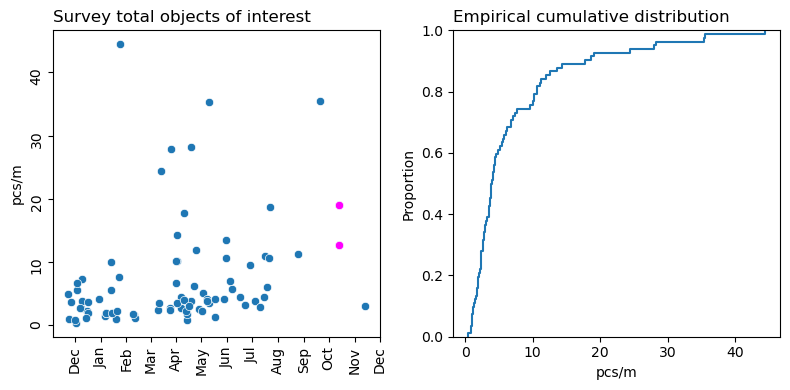

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

one = axs[0]
two = axs[1]

months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
one.xaxis.set_major_locator(months)
one.xaxis.set_major_formatter(months_fmt)

one.tick_params(rotation=90)


sns.scatterplot(data=ctot, x="date", y="pcs_m", ax=one)
sns.scatterplot(data=city_tot, x="date", y="pcs_m", ax=one, color="magenta")
sns.ecdfplot(data=ctot, x="pcs_m", ax=two)
one.set_xlabel("")
one.set_ylabel("pcs/m")
one.set_title("Survey total objects of interest", loc="left")

two.set_title("Empirical cumulative distribution", loc="left")
two.set_xlabel("pcs/m")

plt.tight_layout()


plt.show()

### Chance of exceeding threshold: lake

In [10]:
from scipy.stats import nbinom
from scipy.stats import gamma
from scipy.stats import beta

def check_nk(anarray, threshold):
    gthan = (anarray >= threshold).sum()
    pnk = gthan/len(anarray)

    return pnk, gthan, len(anarray)


def a_nbdist(anarray):
    mu = anarray.mean()
    sigma = anarray.var()

    p = mu/sigma    
    n = mu**2/(sigma-mu)

    nbrv = nbinom(n,p)

    return nbrv
    
    
def a_gammadist(anarray, afunc: callable = None):

    if afunc is not None:
        mu = afunc(anarray)
    else:
        if np.median(anarray) == 0:
            mu = .001
        else:
            mu = np.median(anarray)

    gammadist = gamma(mu)

    return gammadist


def make_inference_from_cdf(prior_dist, current_dist, threshold):

    # hnot: the chance of equal to or greater than threshold
    aprior = 1-prior_dist.cdf(threshold)
    lhood = 1-current_dist.cdf(threshold)

    # hone: the chance that the threshold is not exceeded
    hone_prior = prior_dist.cdf(threshold)
    hone_lhod = current_dist.cdf(threshold)

    normalise = (hone_prior*hone_lhod)+(aprior*lhood)

    return (aprior*lhood)/normalise, (hone_prior*hone_lhod)/normalise

def prior_magnitude_for_a_period(masked, p_results, tholds, cois, uses, magnitude: bool = False):
    res = []
    totals = []
    for i,acode in enumerate(cois):
        d = p_results[p_results.code == acode]
        vals = []
        by_use = {}
        # this is pcs_m for for a land use attribute
        for i, alist in enumerate(masked):
            ksandns, _ = retrieve_k_and_n(alist, p_results[p_results.code == acode], threshold=tholds.loc[acode], magnitude=magnitude)
            vals.extend(ksandns)
            k_and_ns = {uses[i]:ksandns.values}
            by_use.update(k_and_ns)
        res.append({acode:by_use})
        totals.append({acode:vals})
    
    return res, totals


def collect_regional_land_use_bins(data, prior_locations):
    prior_lake = p_ludata.loc[prior_locations].drop_duplicates(["use", "binned"])

    return prior_lake    

def land_use_data_for_group_of_locations(prior_lake):
    prior_bins = prior_lake.groupby("use").binned.unique()
    return prior_bins

def locations_per_bin(prior_bins, p_ludata, uses):

    bin_numbers_per_use = [make_masks(x, prior_bins.loc[x], p_ludata) for x in uses]
    locations_per_bin = [retrieve_similar_locations(list_of_binnumbers, p_ludata) for list_of_binnumbers in bin_numbers_per_use]

    return locations_per_bin

def make_table_of_priors_by_bin(masked, p_results, tholds, cois, uses, magnitude: bool = False, uninformative=False):

    tprior = prior_k_n_for_a_period(masked, p_results, tholds, cois, uses)
    a_prior = k_over_n_for_prior_k_n(tprior)

    if uninformative:
        a_prior = a_prior.apply(lambda x: .5)

    return a_prior
        
def make_table_of_likelihoods(lake_locations, c_results, thresholds):
    lhood = [retrieve_k_and_n(lake_locations, c_results[c_results.code == x], threshold=tholds.loc[x]) for x in cois]
    return lhood

def posterior_dist_p(lhood, a_prior):
    
    # k/n of the current surveys
    hnot = np.array([x[0]/x[1] for x in lhood])

    # if x = 1 or 0 correct to 0.01 or 0.99
    hnot = [x if x > 0 else .001 for x in hnot]
    hnot = [x if x < 1 else .999 for x in hnot]

    # one - the likelihood
    hone = np.array([1 - x for x in hnot])

    # likelihood * prior
    phnot = a_prior * hnot
    phone = [1-x for x in a_prior] * hone

    # normalizing constant
    ptot = phnot + phone
        
    posterior = pd.DataFrame(data=[phnot/ptot, phone/ptot], index=["hnot", "hone"])

    return posterior
    
def p_per_unit(mags, arange: np.ndarray = np.arange(0, 10, step=.01)):
    ps = []
    for alist in mags:
        alist = np.sort(alist)
        wexp = np.array([( alist >= x).sum()/len(alist) for x in arange])
        wexp = [x if x > 0 else .01 for x in wexp]
        wexp = [x if x < 1 else .99 for x in wexp]
        ps.append(wexp)
    return ps

def add_prior_to_df(df, priors):

    # add the k/n from priors to the likelihood df
    df["prior"] = priors["k/n"]

    # the probability that the threshold was not exceeded
    # from both the likelihood and prior
    df["notp"] = 1 - df["k/n"]
    df["notpr"] = 1- df["prior"]

    # likelihood time the prior for both hypothesis
    # the prior threshhold was exceeded or not
    df["lh*prior"] = df["prior"]*df["k/n"]
    df["notp*notpr"] = df["notp"]*df["notpr"]

    # the total probability considering the two hypothesis
    df["ptot"] = df["notp*notpr"]+df["lh*prior"]

    # the normalized probability
    df["p"] =  df["lh*prior"]/df["ptot"]
    return df

In [11]:
x = np.arange(0, 10, step=.01)
up = [.5 for j in x]
k_and_n_args = {
    "land_use_data": p_ludata,
    "prior_locations": prior_locations,
    "parameters": uses,
    "regional_locations":lake_locations,
    "prior_results": p_results,
    "current_results": c_results,
    "thresholds": tholds_r,
    "codes_of_interest": cois
}

kandps = KAndNPriorLikelihood(**k_and_n_args)
pkandns = ProbabilityOfX(current_results=kandps.current_magnitudes, prior_results=kandps.prior_magnitudes, x=x)
landp_args = {
    "current_probabilities": pkandns.current_probability_of_x,
    "prior_probabilities": pkandns.prior_probability_of_x
}

likelihood_and_priors = LikelihoodAndPriors(**landp_args)
uninformative4 = [pd.DataFrame(data={"mag":x,"k/n":j}) for j in up ]

args = {
    "likelihood":likelihood_and_priors.likelihoods,
    "prior_similar_locations": likelihood_and_priors.priors,
    "unopinionated_prior": uninformative4,
    "codes_of_interest": cois,
    "thresholds": tholds_r,
    "time_prior": uninformative4,
    "caption": "Table 12"
}

year_one = PForAGroupOfCodes(**args)
year_one.row_labels = ["prior: informed", "prior: uninformed", "prior: 0.5"]
year_one.combined_results

,Gfrags,G30,G27,Gfoam,G95,Gcaps,G67,G35,G89,G31,G32,G100,G33,G25,G70,G10
prior: informed,0.32,0.58,0.87,0.89,0.54,0.82,0.61,0.40,0.31,0.50,0.27,0.55,0.73,0.76,0.90,0.55
prior: uninformed,0.41,0.55,0.72,0.74,0.52,0.68,0.56,0.45,0.40,0.50,0.38,0.52,0.62,0.63,0.74,0.52
prior: 0.5,0.41,0.55,0.72,0.74,0.52,0.68,0.56,0.45,0.40,0.50,0.38,0.52,0.62,0.63,0.74,0.52


### Chance of exceeding threshold: city

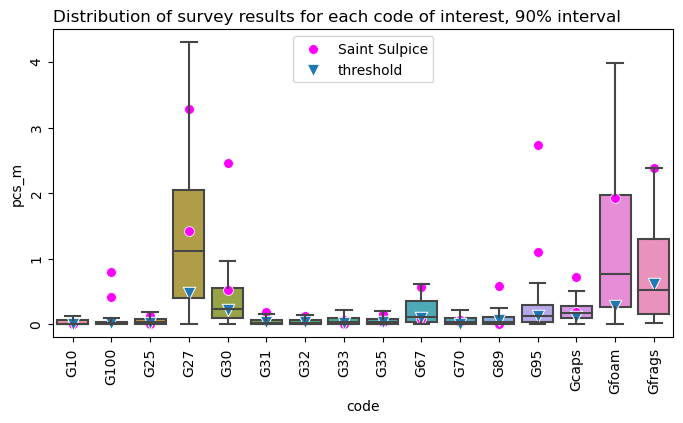

In [12]:
fig, ax = plt.subplots(figsize=(8,4))

sns.boxplot(data=cstart, x="code", y="pcs_m", showfliers=False,ax=ax, width=.8, dodge=True)

sns.scatterplot(data=city_start, x="code", y="pcs_m", ax=ax,s=50, color="magenta", edgecolor="white", label="Saint Sulpice")
sns.scatterplot(data=tholds, x=tholds.index, y=tholds, ax=ax, marker="v", s=80, label="threshold")
ax.tick_params(rotation=90)
ax.set_ylim(-.2, 4.5)
ax.set_title("Distribution of survey results for each code of interest, 90% interval", loc="left")

plt.show()

In [13]:
def bins_and_locations(cs_bins, p_ludata):

    bins = []
    locations = []
    for aset_of_bins in cs_bins:
        masks = [make_masks(x, aset_of_bins.loc[x], p_ludata) for x in aset_of_bins.index]
        masked = [retrieve_similar_locations(amask, p_ludata) for amask in masks]

        bins.append(masks)
        locations.append(masked)
    return bins, locations

def anarray_of_priors(locations, p_results, tholds, cois, cs_bins, uninformative=False):
    priors = []
    for i, alist in enumerate(locations):
        a_prior = make_table_of_priors_by_bin(alist, p_results, tholds, cois, cs_bins[i].index, uninformative=uninformative)
        priors.append(a_prior)

    return priors

def anarray_of_likelihoods(cities, c_results, thresholds):

    locations = []
    for city in cities:
        
        if city in c_results.city.unique():
            locations.append(c_results[c_results.city == city].location.unique())    
            
    likelihoods = []        
    for i, places in enumerate(locations):
        likelihood = make_table_of_likelihoods(places, c_results, thresholds)
        likelihoods.append(likelihood)

    return likelihoods

def anarray_of_posteriors(lhoods, priors):

    posts = []
    for i, hood in enumerate(lhoods):
        posterior = posterior_dist_p(hood, priors[i])
        posts.append(posterior)
    return posts

def current_magnitudes_for_group(list_locations, current_results, thresholds, cois):
    mags_current = [retrieve_k_and_n(list_locations, current_results[current_results.code == x], threshold=thresholds.loc[x], magnitude=True) for x in cois]

    return [x[0].values for x in mags_current]

def prior_magnitudes_for_group(list_locations, prior_results, thresholds, cois, uses):
    prior_use_group, prior_totals_group  = prior_magnitude_for_a_period(list_locations, prior_results, thresholds, cois, uses, magnitude=True)

    return [np.array(x[cois[i]]) for i,x in enumerate(prior_totals_group)], prior_use_group

def probability_per_magnitude_df(p_mag, x):
    
    return [pd.DataFrame(data={"mag":x,"k/n":j}) for j in p_mag]
    

def posterior_for_a_city(city_locations, similar_locations, c_results, p_results, tholds, x, cois, uses, alt_prior: list=None):
    mags_city = current_magnitudes_for_group(city_locations, c_results, tholds, cois)
    prior_totals_city, prior_use_city  = prior_magnitudes_for_group(similar_locations, p_results, tholds, cois, uses)

    wec = p_per_unit(mags_city)
    psc = p_per_unit(prior_totals_city)

    likely_c = probability_per_magnitude_df(wec, x)
    likelypriors_c = probability_per_magnitude_df(psc, x)
    

    p_prior_similar = [add_prior_to_df(x.copy(), likelypriors_c[i]) for i, x in enumerate(likely_c)]

    if alt_prior:
        alternate_prior = probability_per_magnitude_df(alt_prior, x)
        p_prior_un = [add_prior_to_df(x.copy(), alternate_prior[i]) for i, x in enumerate(likely_c)]

        return p_prior_similar, p_prior_un

    else:
        return p_prior_similar


In [14]:
cities = ['Genève', 'Saint-Gingolph', 'Saint-Sulpice (VD)']
# cities = sorted(cities)

city_index = 0

k_and_n_args = {
    "city": cities[city_index], 
    "current_survey_results": c_results ,
    "land_use_data": p_ludata,
    "codes_of_interest": cois, 
    "thresholds": tholds_r,
    "prior_results": p_results,
    "parameters": uses, 
    "unopinionated": up,
}

citykandps = ProbabilityForACity(**k_and_n_args)

citypkandns = ProbabilityOfX(current_results=citykandps.current_magnitudes, prior_results=citykandps.prior_magnitudes, x=x)


landp_args = {
    "current_probabilities": citypkandns.current_probability_of_x,
    "prior_probabilities": citypkandns.prior_probability_of_x
}

likelihood_and_priors = LikelihoodAndPriors(**landp_args)
uninformative4city = [pd.DataFrame(data={"mag":x,"k/n":j}) for j in up ]

args = {
    "likelihood":likelihood_and_priors.likelihoods,
    "prior_similar_locations": likelihood_and_priors.priors,
    "unopinionated_prior": uninformative4city,
    "codes_of_interest": cois,
    "thresholds": tholds_r,
    "time_prior": uninformative4city,
    "caption": "Table 13: Probability of exceeding threshold at Genève under different priors",
}

year_one_city_g= PForAGroupOfCodes(**args)
year_one_city_g.row_labels = ["prior: informed", "prior: year two posterior", "prior: 0.5"]
# year_one_city_g.combined_results

In [15]:
city_index = 1

k_and_n_args = {
    "city": cities[city_index], 
    "current_survey_results": c_results ,
    "land_use_data": p_ludata,
    "codes_of_interest": cois, 
    "thresholds": tholds_r,
    "prior_results": p_results,
    "parameters": uses, 
    "unopinionated": up,
}

citykandps = ProbabilityForACity(**k_and_n_args)

citypkandns = ProbabilityOfX(current_results=citykandps.current_magnitudes, prior_results=citykandps.prior_magnitudes, x=x)


landp_args = {
    "current_probabilities": citypkandns.current_probability_of_x,
    "prior_probabilities": citypkandns.prior_probability_of_x
}

likelihood_and_priors = LikelihoodAndPriors(**landp_args)
uninformative4city = [pd.DataFrame(data={"mag":x,"k/n":j}) for j in up ]

args = {
    "likelihood":likelihood_and_priors.likelihoods,
    "prior_similar_locations": likelihood_and_priors.priors,
    "unopinionated_prior": uninformative4city,
    "codes_of_interest": cois,
    "thresholds": tholds_r,
    "time_prior": uninformative4city,
    "caption": "Table 13: Probability of exceeding threshold at Saint Gingolph under different priors",
}

year_one_city_stg= PForAGroupOfCodes(**args)
year_one_city_stg.row_labels = ["prior: informed", "prior: year two posterior", "prior: 0.5"]
# year_one_city_stg.combined_results

In [16]:
city_index = 2

k_and_n_args = {
    "city": cities[city_index], 
    "current_survey_results": c_results ,
    "land_use_data": p_ludata,
    "codes_of_interest": cois, 
    "thresholds": tholds_r,
    "prior_results": p_results,
    "parameters": uses, 
    "unopinionated": up,
}

citykandps = ProbabilityForACity(**k_and_n_args)

citypkandns = ProbabilityOfX(current_results=citykandps.current_magnitudes, prior_results=citykandps.prior_magnitudes, x=x)


landp_args = {
    "current_probabilities": citypkandns.current_probability_of_x,
    "prior_probabilities": citypkandns.prior_probability_of_x
}

likelihood_and_priors = LikelihoodAndPriors(**landp_args)
uninformative4city = [pd.DataFrame(data={"mag":x,"k/n":j}) for j in up ]

args = {
    "likelihood":likelihood_and_priors.likelihoods,
    "prior_similar_locations": likelihood_and_priors.priors,
    "unopinionated_prior": uninformative4city,
    "codes_of_interest": cois,
    "thresholds": tholds_r,
    "time_prior": uninformative4city,
    "caption": "Table 13: Probability of exceeding threshold at Saint Sulpice under different priors",
}

year_one_city_spc= PForAGroupOfCodes(**args)
year_one_city_spc.row_labels = ["prior: informed", "prior: year two posterior", "prior: 0.5"]
# year_one_city_spc.combined_results

## Sampling period two: April 2017 - May 2018

In [17]:
slr_d = make_date_object("2017-04-01")
slr_e = make_date_object("2018-05-01")
date_mask = (all_data["date"] >= slr_d) & (all_data["date"] <= slr_e)

lake_locations = all_data[date_mask & (all_data.water_name_slug == 'lac-leman')].location.unique()
prior_locations = all_data[date_mask&(all_data.water == "l")].location.unique()

# the survey results and land use attributes associated with the locations
# included in the survey results
p_results, p_ludata = results_and_land_use(all_data, land_use_agg, slr_e, prior_locations, cois)
c_results = p_results[p_results.date >= slr_d ]
city_results = c_results[c_results.city == coi]
uses = p_ludata.use.unique()

# sample totals per code
ctot = c_results.groupby(["loc_date", "date"], as_index=False).pcs_m.sum()
city_tot = city_results.groupby(["loc_date", "date"], as_index=False).pcs_m.sum()
city_start = city_results.groupby(["loc_date", "date", "code"], as_index=False).pcs_m.sum()
cstart = c_results.groupby(["loc_date", "date", "code"], as_index=False).pcs_m.sum()
cmedian = cstart.groupby("code", as_index=False).pcs_m.mean()

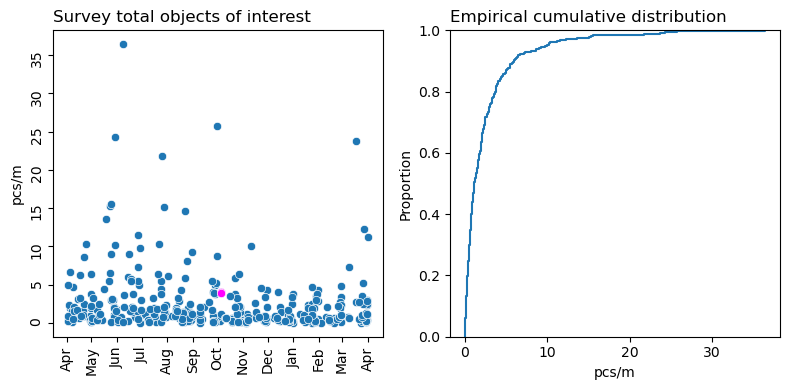

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

one = axs[0]
two = axs[1]

months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
one.xaxis.set_major_locator(months)
one.xaxis.set_major_formatter(months_fmt)

one.tick_params(rotation=90)


sns.scatterplot(data=ctot, x="date", y="pcs_m", ax=one)
sns.scatterplot(data=city_tot, x="date", y="pcs_m", ax=one, color="magenta")
sns.ecdfplot(data=ctot, x="pcs_m", ax=two)
one.set_xlabel("")
one.set_ylabel("pcs/m")
one.set_title("Survey total objects of interest", loc="left")

two.set_title("Empirical cumulative distribution", loc="left")
two.set_xlabel("pcs/m")

plt.tight_layout()


plt.show()

### Chance of exceeding threshold: lake

In [19]:
x = np.arange(0, 10, step=.01)
up = [.5 for j in x]
k_and_n_args = {
    "land_use_data": p_ludata,
    "prior_locations": prior_locations,
    "parameters": uses,
    "regional_locations":lake_locations,
    "prior_results": p_results,
    "current_results": c_results,
    "thresholds": tholds_r,
    "codes_of_interest": cois
}

kandps = KAndNPriorLikelihood(**k_and_n_args)
pkandns = ProbabilityOfX(current_results=kandps.current_magnitudes, prior_results=kandps.prior_magnitudes, x=x)
landp_args = {
    "current_probabilities": pkandns.current_probability_of_x,
    "prior_probabilities": pkandns.prior_probability_of_x
}

likelihood_and_priors = LikelihoodAndPriors(**landp_args)
uninformative4 = [pd.DataFrame(data={"mag":x,"k/n":j}) for j in up ]

args = {
    "likelihood":likelihood_and_priors.likelihoods,
    "prior_similar_locations": likelihood_and_priors.priors,
    "unopinionated_prior": uninformative4,
    "codes_of_interest": cois,
    "thresholds": tholds_r,
    "time_prior": year_one.uninformed_prior,
    "caption": "Table 12"
}

year_two = PForAGroupOfCodes(**args)
year_two.row_labels = ["prior: informed", "prior: year two posterior", "prior: 0.5"]
# year_two.combined_results

### Chance of exceeding threshold: city

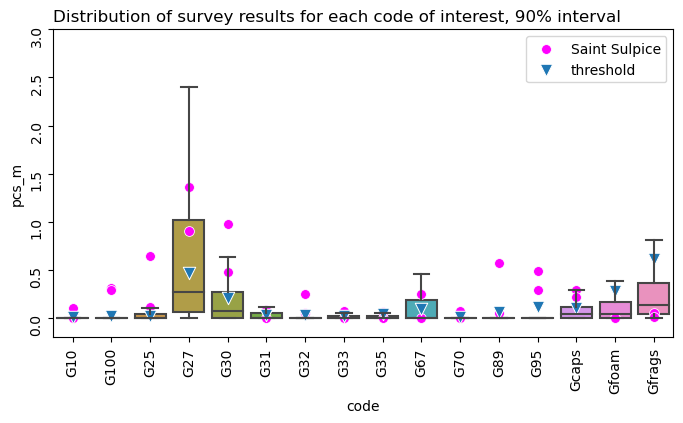

In [20]:
fig, ax = plt.subplots(figsize=(8,4))

sns.boxplot(data=cstart, x="code", y="pcs_m", showfliers=False,ax=ax, width=.8, dodge=True)

sns.scatterplot(data=city_start, x="code", y="pcs_m", ax=ax,s=50, color="magenta", edgecolor="white", label="Saint Sulpice")
sns.scatterplot(data=tholds, x=tholds.index, y=tholds, ax=ax, marker="v", s=80, label="threshold")
ax.tick_params(rotation=90)
ax.set_ylim(-.2, 3)
ax.set_title("Distribution of survey results for each code of interest, 90% interval", loc="left")

plt.show()

In [21]:
cities = ['Genève', 'Saint-Gingolph', 'Saint-Sulpice (VD)']
# cities = sorted(cities)

city_index = 1

k_and_n_args = {
    "city": cities[city_index], 
    "current_survey_results": c_results ,
    "land_use_data": p_ludata,
    "codes_of_interest": cois, 
    "thresholds": tholds_r,
    "prior_results": p_results,
    "parameters": uses, 
    "unopinionated": up,
}

citykandps = ProbabilityForACity(**k_and_n_args)

citypkandns = ProbabilityOfX(current_results=citykandps.current_magnitudes, prior_results=citykandps.prior_magnitudes, x=x)


landp_args = {
    "current_probabilities": citypkandns.current_probability_of_x,
    "prior_probabilities": citypkandns.prior_probability_of_x
}

likelihood_and_priors = LikelihoodAndPriors(**landp_args)
uninformative4city = [pd.DataFrame(data={"mag":x,"k/n":j}) for j in up ]

args = {
    "likelihood":likelihood_and_priors.likelihoods,
    "prior_similar_locations": likelihood_and_priors.priors,
    "unopinionated_prior": uninformative4city,
    "codes_of_interest": cois,
    "thresholds": tholds_r,
    "time_prior": year_one_city_stg.uninformed_prior,
    "caption": "Table 13: Probability of exceeding threshold at Saint Gingolph under different priors",
}

year_two_city_stg= PForAGroupOfCodes(**args)
year_two_city_stg.row_labels = ["prior: informed", "prior: year two posterior", "prior: 0.5"]
# year_two_city_stg.combined_results

In [22]:
city_index = 2

k_and_n_args = {
    "city": cities[city_index], 
    "current_survey_results": c_results ,
    "land_use_data": p_ludata,
    "codes_of_interest": cois, 
    "thresholds": tholds_r,
    "prior_results": p_results,
    "parameters": uses, 
    "unopinionated": up,
}

citykandps = ProbabilityForACity(**k_and_n_args)

citypkandns = ProbabilityOfX(current_results=citykandps.current_magnitudes, prior_results=citykandps.prior_magnitudes, x=x)


landp_args = {
    "current_probabilities": citypkandns.current_probability_of_x,
    "prior_probabilities": citypkandns.prior_probability_of_x
}

likelihood_and_priors = LikelihoodAndPriors(**landp_args)
uninformative4city = [pd.DataFrame(data={"mag":x,"k/n":j}) for j in up ]

args = {
    "likelihood":likelihood_and_priors.likelihoods,
    "prior_similar_locations": likelihood_and_priors.priors,
    "unopinionated_prior": uninformative4city,
    "codes_of_interest": cois,
    "thresholds": tholds_r,
    "time_prior": year_one_city_spc.uninformed_prior,
    "caption": "Table 13: Probability of exceeding threshold at Saint Sulpice under different priors",
}

year_two_city_spc= PForAGroupOfCodes(**args)
year_two_city_spc.row_labels = ["prior: informed", "prior: year two posterior", "prior: 0.5"]
# year_two_city_spc.combined_results

## Sampling period three: April 2020 - May 2021

In [23]:
slr_d = make_date_object("2020-04-01")
slr_e = make_date_object("2021-05-01")
date_mask =  (all_data["date"] >= slr_d) & (all_data["date"] <= slr_e)

lake_locations = all_data[date_mask & (all_data.water_name_slug == 'lac-leman')].location.unique()
prior_locations = all_data[(all_data["date"] <= slr_e) &(all_data.water_name_slug == 'lac-leman')].location.unique()

# the survey results and land use attributes associated with the locations
# included in the survey results
p_results, p_ludata = results_and_land_use(all_data, land_use_agg, slr_e, prior_locations, cois)

c_results = p_results[p_results.date >= slr_d ]
city_results = c_results[c_results.city == coi]
uses = p_ludata.use.unique()

# sample totals per code
ctot = c_results.groupby(["loc_date", "date"], as_index=False).pcs_m.sum()
city_tot = city_results.groupby(["loc_date", "date"], as_index=False).pcs_m.sum()
city_start = city_results.groupby(["loc_date", "date", "code"], as_index=False).pcs_m.sum()
cstart = c_results.groupby(["loc_date", "date", "code"], as_index=False).pcs_m.sum()
cmedian = cstart.groupby("code", as_index=False).pcs_m.mean()

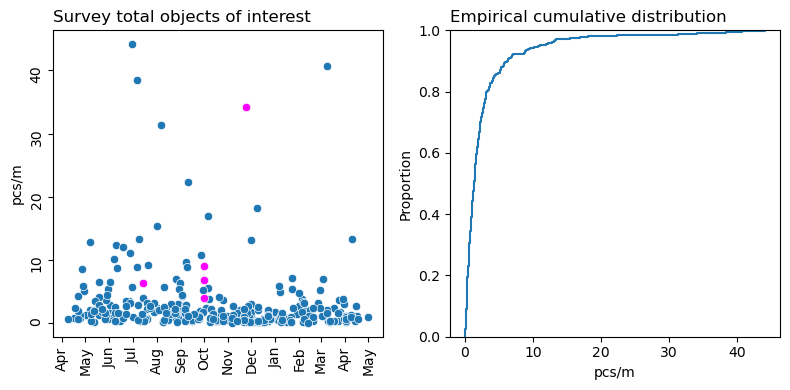

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

one = axs[0]
two = axs[1]

months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
one.xaxis.set_major_locator(months)
one.xaxis.set_major_formatter(months_fmt)

one.tick_params(rotation=90)


sns.scatterplot(data=ctot, x="date", y="pcs_m", ax=one)
sns.scatterplot(data=city_tot, x="date", y="pcs_m", ax=one, color="magenta")
sns.ecdfplot(data=ctot, x="pcs_m", ax=two)
one.set_xlabel("")
one.set_ylabel("pcs/m")
one.set_title("Survey total objects of interest", loc="left")

two.set_title("Empirical cumulative distribution", loc="left")
two.set_xlabel("pcs/m")

plt.tight_layout()


plt.show()

### Chance of exceeding threshold: lake

In [25]:
x = np.arange(0, 10, step=.01)
up = [.5 for j in x]
k_and_n_args = {
    "land_use_data": p_ludata,
    "prior_locations": prior_locations,
    "parameters": uses,
    "regional_locations":lake_locations,
    "prior_results": p_results,
    "current_results": c_results,
    "thresholds": tholds_r,
    "codes_of_interest": cois
}

kandps = KAndNPriorLikelihood(**k_and_n_args)
pkandns = ProbabilityOfX(current_results=kandps.current_magnitudes, prior_results=kandps.prior_magnitudes, x=x)
landp_args = {
    "current_probabilities": pkandns.current_probability_of_x,
    "prior_probabilities": pkandns.prior_probability_of_x
}

likelihood_and_priors = LikelihoodAndPriors(**landp_args)
uninformative4 = [pd.DataFrame(data={"mag":x,"k/n":j}) for j in up ]

args = {
    "likelihood":likelihood_and_priors.likelihoods,
    "prior_similar_locations": likelihood_and_priors.priors,
    "unopinionated_prior": uninformative4,
    "codes_of_interest": cois,
    "thresholds": tholds_r,
    "time_prior": year_two.uninformed_prior,
    "caption": "Table 12"
}

year_three = PForAGroupOfCodes(**args)
year_three.row_labels = ["prior: informed", "prior: year two posterior", "prior: 0.5"]
year_three.combined_results

,Gfrags,G30,G27,Gfoam,G95,Gcaps,G67,G35,G89,G31,G32,G100,G33,G25,G70,G10
prior: informed,0.45,0.54,0.55,0.56,0.63,0.61,0.56,0.54,0.43,0.58,0.43,0.61,0.56,0.57,0.57,0.45
prior: year two posterior,0.37,0.59,0.52,0.35,0.75,0.64,0.55,0.48,0.18,0.61,0.26,0.52,0.40,0.46,0.19,0.29
prior: 0.5,0.51,0.51,0.47,0.51,0.54,0.51,0.53,0.55,0.51,0.55,0.51,0.57,0.54,0.53,0.53,0.51


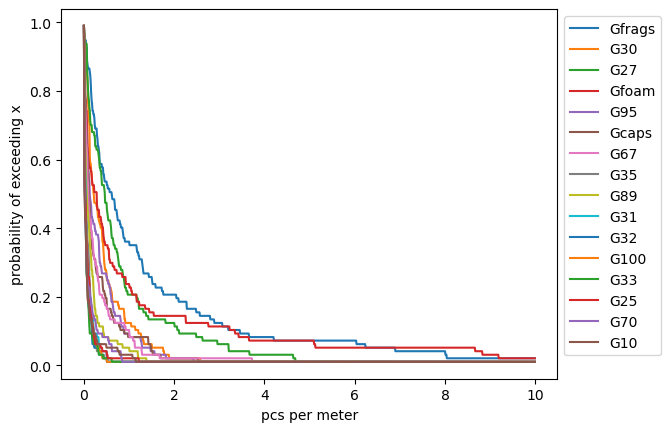

In [26]:
fig, ax = plt.subplots()

for i,res in enumerate(year_three.uninformed_prior):
    sns.lineplot(data=res, x="mag", y="p", ax=ax, label=cois[i])
    # sns.lineplot(data=spc3[i], x="mag", y="p", ax=ax, label=cois[i])

ax.set_xlabel("pcs per meter")
ax.set_ylabel("probability of exceeding x")
ax.legend(bbox_to_anchor=(1,1))
plt.show()

### Chance of exceeding threshold: city

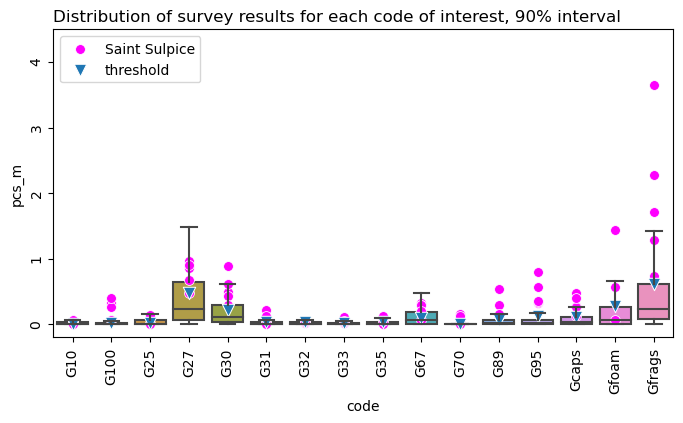

In [27]:
fig, ax = plt.subplots(figsize=(8,4))

sns.boxplot(data=cstart, x="code", y="pcs_m", showfliers=False,ax=ax, width=.8, dodge=True)

sns.scatterplot(data=city_start, x="code", y="pcs_m", ax=ax,s=50, color="magenta", edgecolor="white", label="Saint Sulpice")
sns.scatterplot(data=tholds, x=tholds.index, y=tholds, ax=ax, marker="v", s=80, label="threshold")
ax.tick_params(rotation=90)
ax.set_ylim(-.2, 4.5)
ax.set_title("Distribution of survey results for each code of interest, 90% interval", loc="left")
ax.legend(loc="upper left")

plt.show()

### Chance of exceeding threshold: city

In [28]:
cities = ['Genève', 'Saint-Gingolph', 'Saint-Sulpice (VD)']

city_index = 0

k_and_n_args = {
    "city": cities[city_index], 
    "current_survey_results": c_results ,
    "land_use_data": p_ludata,
    "codes_of_interest": cois, 
    "thresholds": tholds_r,
    "prior_results": p_results,
    "parameters": uses, 
    "unopinionated": up,
}

citykandps = ProbabilityForACity(**k_and_n_args)

citypkandns = ProbabilityOfX(current_results=citykandps.current_magnitudes, prior_results=citykandps.prior_magnitudes, x=x)


landp_args = {
    "current_probabilities": citypkandns.current_probability_of_x,
    "prior_probabilities": citypkandns.prior_probability_of_x
}

likelihood_and_priors = LikelihoodAndPriors(**landp_args)
uninformative4city = [pd.DataFrame(data={"mag":x,"k/n":j}) for j in up ]

args = {
    "likelihood":likelihood_and_priors.likelihoods,
    "prior_similar_locations": likelihood_and_priors.priors,
    "unopinionated_prior": uninformative4city,
    "codes_of_interest": cois,
    "thresholds": tholds_r,
    "time_prior": year_one_city_g.uninformed_prior,
    "caption": "Table 13: Probability of exceeding threshold at Geneva under different priors",
}

year_three_city_g= PForAGroupOfCodes(**args)
year_three_city_g.row_labels = ["prior: informed", "prior: year two posterior", "prior: 0.5"]
year_three_city_g.combined_results

,Gfrags,G30,G27,Gfoam,G95,Gcaps,G67,G35,G89,G31,G32,G100,G33,G25,G70,G10
prior: informed,0.16,0.29,0.42,0.07,0.14,0.15,0.14,0.36,0.13,0.12,0.17,0.25,0.45,0.24,0.24,0.24
prior: year two posterior,0.72,0.79,0.69,0.87,0.22,0.30,0.61,0.38,0.10,0.07,0.10,0.14,0.70,0.14,0.14,0.19
prior: 0.5,0.19,0.25,0.31,0.06,0.12,0.12,0.12,0.38,0.19,0.12,0.25,0.25,0.44,0.25,0.25,0.31


In [29]:
city_index = 1

k_and_n_args = {
    "city": cities[city_index], 
    "current_survey_results": c_results ,
    "land_use_data": p_ludata,
    "codes_of_interest": cois, 
    "thresholds": tholds_r,
    "prior_results": p_results,
    "parameters": uses, 
    "unopinionated": up,
}

citykandps = ProbabilityForACity(**k_and_n_args)

citypkandns = ProbabilityOfX(current_results=citykandps.current_magnitudes, prior_results=citykandps.prior_magnitudes, x=x)

landp_args = {
    "current_probabilities": citypkandns.current_probability_of_x,
    "prior_probabilities": citypkandns.prior_probability_of_x
}

likelihood_and_priors = LikelihoodAndPriors(**landp_args)

args = {
    "likelihood":likelihood_and_priors.likelihoods,
    "prior_similar_locations": likelihood_and_priors.priors,
    "unopinionated_prior": uninformative4city,
    "codes_of_interest": cois,
    "thresholds": tholds_r,
    "time_prior": year_two_city_stg.uninformed_prior,
    "caption": "Table 13: Probability of exceeding threshold at Saint Gingolph under different priors",
}

year_three_city_sg= PForAGroupOfCodes(**args)
year_three_city_sg.row_labels =  ["prior: informed", "prior: year two posterior", "prior: 0.5"]
year_three_city_sg.combined_results

,Gfrags,G30,G27,Gfoam,G95,Gcaps,G67,G35,G89,G31,G32,G100,G33,G25,G70,G10
prior: informed,0.93,0.95,0.12,1.00,1.00,0.97,1.00,0.94,0.99,1.00,1.00,0.91,1.00,0.89,1.00,1.00
prior: year two posterior,0.09,1.00,0.00,1.00,1.00,1.00,1.00,0.09,0.50,1.00,1.00,1.00,0.50,1.00,1.00,1.00
prior: 0.5,0.91,0.91,0.18,0.99,0.99,0.91,0.99,0.91,0.99,0.99,0.99,0.82,0.99,0.82,0.99,0.99


In [30]:
city_index = 2

k_and_n_args = {
    "city": cities[city_index], 
    "current_survey_results": c_results ,
    "land_use_data": p_ludata,
    "codes_of_interest": cois, 
    "thresholds": tholds_r,
    "prior_results": p_results,
    "parameters": uses, 
    "unopinionated": up,
}

citykandps = ProbabilityForACity(**k_and_n_args)

citypkandns = ProbabilityOfX(current_results=citykandps.current_magnitudes, prior_results=citykandps.prior_magnitudes, x=x)

landp_args = {
    "current_probabilities": citypkandns.current_probability_of_x,
    "prior_probabilities": citypkandns.prior_probability_of_x
}

likelihood_and_priors = LikelihoodAndPriors(**landp_args)

args = {
    "likelihood":likelihood_and_priors.likelihoods,
    "prior_similar_locations": likelihood_and_priors.priors,
    "unopinionated_prior": uninformative4city,
    "codes_of_interest": cois,
    "thresholds": tholds_r,
    "time_prior": year_two_city_spc.uninformed_prior,
    "caption": "Table 13: Probability of exceeding threshold at Saint Sulpice under different priors",
}

year_three_city_sp= PForAGroupOfCodes(**args)
year_three_city_sp.row_labels = ["prior: informed", "prior: year two posterior", "prior: 0.5"]
year_three_city_sp.combined_results

,Gfrags,G30,G27,Gfoam,G95,Gcaps,G67,G35,G89,G31,G32,G100,G33,G25,G70,G10
prior: informed,0.99,1.00,0.89,0.87,0.99,0.99,0.87,0.85,0.99,0.69,0.79,0.99,0.99,0.48,0.83,0.56
prior: year two posterior,0.50,1.00,1.00,0.04,1.00,1.00,0.80,0.80,0.99,0.60,1.00,1.00,0.99,0.99,0.80,0.60
prior: 0.5,0.99,0.99,0.80,0.80,0.99,0.99,0.80,0.80,0.99,0.60,0.80,0.99,0.99,0.40,0.80,0.60


## Samples after May 2021

### Expected results for Saint Sulpice

__Observed results October 2021: SWE__

In [31]:
def is_in_range(x, arange):
    acount = 0
    lows = 0
    highs = 0
    
    if isinstance(x, float):    
        gthan = x >= arange[1]
        lthan = x <= arange[2]
        if gthan and lthan:
            ontarget = True
            dif = 0
            acount += 1
        elif not gthan:
            ontarget = "high"
            dif = arange[1] - x
            highs += 1
            
        elif not lthan:
            ontarget = "low"
            dif = arange[2] - x
            lows += 1
    else:
        ontarget = "No data"
        dif = None
    
    return arange[0], ontarget, dif, acount, highs, lows


lake_after_may = all_data[(all_data.date > slr_e) & (all_data.water_name_slug == 'lac-leman')]
after_may_location = lake_after_may.location.unique()
l_a_m = lake_after_may[lake_after_may.code.isin(cois)]
l_a_mx = l_a_m[l_a_m.location.isin(['plage-de-st-sulpice', 'tiger_duck_beach'])]
lam = l_a_mx.groupby("code", as_index=False).pcs_m.mean()
lm = pd.DataFrame(data=lam.pcs_m.values, index=lam.code).T
xlmc = lm[cois]
xlmcv = xlmc.values[0]
xlmc

code,Gfrags,G30,G27,Gfoam,G95,Gcaps,G67,G35,G89,G31,G32,G100,G33,G25,G70,G10
0,1.53,0.35,0.07,0.0,0.17,0.15,0.12,0.0,0.17,0.1,0.03,0.1,0.0,0.03,0.03,0.03


#### The probability of the observed results at Saint Sulpice given the informed posterior from lake

The observed results +/- .1. See table 12 for probability of the event at the lake.

In [32]:
# the probability of the result after may 2021
h = [x.loc[(x.mag >= xlmcv[i] - .1)&(x.mag <= xlmcv[i] + .1)] for i, x in enumerate(year_three.informed_prior)]
hg = [(cois[i],np.round(x.p.min(), 2), np.round(x.p.max(), 2)) for i, x in enumerate(h)]

# the expected range magnitude with a 96% probability
t = [x.loc[(x.p >= .03) & (x.p <= .97)].mag for i, x in enumerate(year_three.informed_prior)]
tr = [(cois[i], round(x.min(), 2),  round(x.max(), 2)) for i,x in enumerate(t)]

tested = [is_in_range(xlmcv[i], x) for i, x in enumerate(tr)]
print("\nDid the observed results fall within the predicted range?")
in_range = sum([x[3] for x in tested])
arange = len(tested)
highs = sum([x[4] for x in tested])
lows = sum([x[5] for x in tested])
print(f"In range: {in_range}, out of: {arange}\n")
print(f"Estmiated high: {highs}, Estimated low: {lows}")


Did the observed results fall within the predicted range?
In range: 12, out of: 16

Estmiated high: 4, Estimated low: 0


#### The probability of the observed results at Saint Sulpice given the informed posterior from Saint Sulpice

The observed results +/- .1. See table 14 for the probability of the event at Saint Sulpice.

In [33]:
# saint sulpice
# the probability of the result after may 2021
h = [x.loc[(x.mag >= xlmcv[i] - .1) & (x.mag <= xlmcv[i] + .1)].p for i, x in enumerate(year_three_city_sp.informed_prior)]
# [(cois[i], round(x.min(), 2), round(x.max(), 2)) for i, x in enumerate(h)]

# the expected magnitude with probability between .3 and .6
a_p_for_index = year_three_city_sp.informed_prior
t = [x.loc[(x.p >= .03) & (x.p <= .97)].mag for i, x in enumerate(a_p_for_index)]
tr = [(cois[i], round(x.min(), 2),  round(x.max(), 2)) for i,x in enumerate(t)]


# pstk_gfrags = pstock[pstock.code == "Gfrags"].copy()
# pstk_res = pstk_gfrags["pcs/m"].values

tested = [is_in_range(xlmcv[i], x) for i, x in enumerate(tr)]
print("\nDid the observed results fall within the predicted range?")
in_range = sum([x[3] for x in tested])
arange = len(tested)
highs = sum([x[4] for x in tested])
lows = sum([x[5] for x in tested])
# print(f"96% probability range = {tr[0]}")
print(f"In range: {in_range}, out of: {arange} or {round(in_range/arange, 2)}\n")
print(f"Estmiated high: {highs}, Estimated low: {lows}")


Did the observed results fall within the predicted range?
In range: 11, out of: 16 or 0.69

Estmiated high: 5, Estimated low: 0


### Plastock

100 samples from 2022 on lac leman

In [34]:
plastock = pd.read_csv("resources/pstock_2022.csv")
plastock["loc_date"] = list(zip(plastock.location, plastock.date))
pstock = plastock[plastock.code.isin(cois)].copy()
pstock = pstock.groupby(["loc_date", "location", "date", "code"], as_index=False)["pcs/m"].sum()
pstock = pstock.groupby(["location", "code"], as_index=False)["pcs/m"].mean()

In [35]:
a_p_for_index = year_three.informed_prior
t = [x.loc[(x.p >= .03) & (x.p <= .97)].mag for i, x in enumerate(a_p_for_index)]
tr = [(cois[i], round(x.min(), 2),  round(x.max(), 2)) for i,x in enumerate(t)]

pstk_gfrags = pstock[pstock.code == "Gfrags"].copy()
pstk_res = pstk_gfrags["pcs/m"].values

tested = [is_in_range(x, tr[0]) for x in pstk_res]

print("\nDid the observed results fall within the predicted range?")
in_range = sum([x[3] for x in tested])
arange = len(tested)
highs = sum([x[4] for x in tested])
lows = sum([x[5] for x in tested])
print(f"96% probability range = {tr[0]}")
print(f"In range: {in_range}, out of: {arange} or {round(in_range/arange, 2)}\n")
print(f"Estmiated high: {highs}, Estimated low: {lows}")


Did the observed results fall within the predicted range?
96% probability range = ('Gfrags', 0.12, 2.27)
In range: 20, out of: 25 or 0.8

Estmiated high: 1, Estimated low: 4


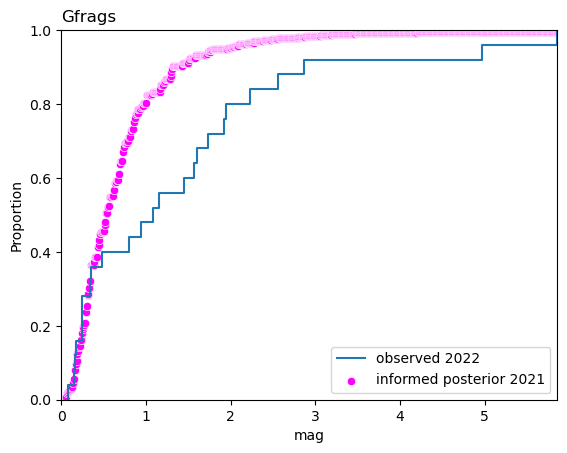

In [36]:
d = a_p_for_index[0]
d["1-p"] = 1- d.p 

fig, ax = plt.subplots()

sns.ecdfplot(pstk_res, ax=ax, label="observed 2022")
sns.scatterplot(data=d, x="mag", y="1-p", ax=ax, color="magenta", label="informed posterior 2021")
ax.set_xlim(0, pstk_res.max())
ax.set_title(cois[0], loc="left")

plt.show()

In [37]:
pstk_gfrags = pstock[pstock.code == "G27"].copy()
pstk_res = pstk_gfrags["pcs/m"].values

tested = [is_in_range(x, tr[2]) for x in pstk_res]
print("\nDid the observed results fall within the predicted range?")
in_range = sum([x[3] for x in tested])
arange = len(tested)
highs = sum([x[4] for x in tested])
lows = sum([x[5] for x in tested])
print(f"96% probability range = {tr[2]}")
print(f"In range: {in_range}, out of: {arange} or {round(in_range/arange, 2)}\n")
print(f"Estmiated high: {highs}, Estimated low: {lows}")


Did the observed results fall within the predicted range?
96% probability range = ('G27', 0.08, 2.06)
In range: 19, out of: 25 or 0.76

Estmiated high: 5, Estimated low: 1


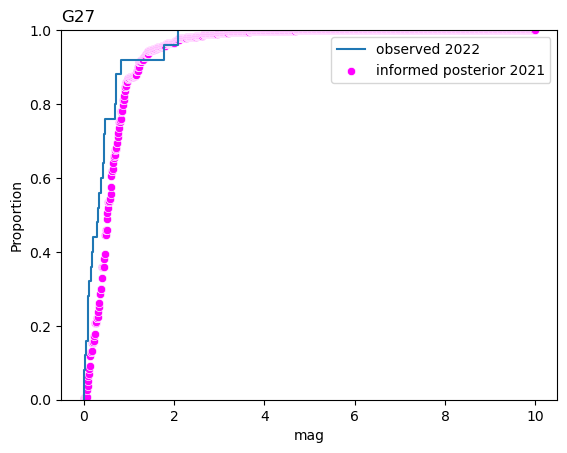

In [38]:
d = a_p_for_index[2]
d["1-p"] = 1- d.p 

fig, ax = plt.subplots()

sns.ecdfplot(pstk_res, ax=ax, label="observed 2022")
sns.scatterplot(data=d, x="mag", y="1-p", ax=ax, color="magenta", label="informed posterior 2021")
ax.set_title(cois[2], loc="left")

plt.show()

In [39]:
pstk_gfrags = pstock[pstock.code == "G95"].copy()
pstk_res = pstk_gfrags["pcs/m"].values

tested = [is_in_range(x, tr[4]) for x in pstk_res]
print("\nDid the observed results fall within the predicted range?")
in_range = sum([x[3] for x in tested])
arange = len(tested)
highs = sum([x[4] for x in tested])
lows = sum([x[5] for x in tested])
print(f"96% probability range = {tr[4]}")
print(f"In range: {in_range}, out of: {arange} or {round(in_range/arange, 2)}\n")
print(f"Estmiated high: {highs}, Estimated low: {lows}")


Did the observed results fall within the predicted range?
96% probability range = ('G95', 0.01, 0.8)
In range: 17, out of: 25 or 0.68

Estmiated high: 8, Estimated low: 0


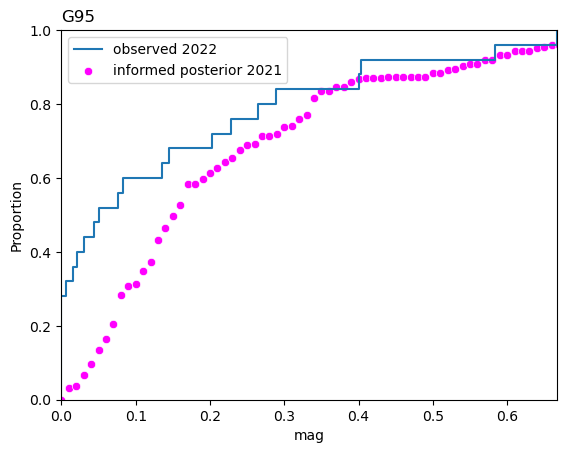

In [40]:
d = a_p_for_index[4]
d["1-p"] = 1- d.p 

fig, ax = plt.subplots()

sns.ecdfplot(pstk_res, ax=ax, label="observed 2022")
sns.scatterplot(data=d, x="mag", y="1-p", ax=ax, color="magenta", label="informed posterior 2021")
ax.set_xlim(0, pstk_res.max())
ax.set_title(cois[4], loc="left")

plt.show()

#### Expected values and predictions plastock

In [41]:
plastock = pd.read_csv("resources/pstock_2022.csv")
plastock["loc_date"] = list(zip(plastock.location, plastock.date))
pstock = plastock[plastock.code.isin(cois)].copy()
pstock = pstock.groupby(["loc_date", "location", "date", "code"], as_index=False)["pcs/m"].sum()
pstock = pstock.groupby(["location", "code"], as_index=False)["pcs/m"].mean()

a_p_for_index = year_three.informed_prior
t = [x.loc[(x.p >= .03) & (x.p <= .97)].mag for i, x in enumerate(a_p_for_index)]
tr = [(cois[i], round(x.min(), 2),  round(x.max(), 2)) for i,x in enumerate(t)]

pst = [np.round(pstock[pstock.code == x]["pcs/m"].values, 2) for x in cois]

n = 0
inn = 0
ress = []
for i,x in enumerate(pst):
    tested = [is_in_range(j, tr[i]) for j in x]
    # print("\nDid the observed results fall within the predicted range?")
    in_range = sum([k[3] for k in tested])
    arange = len(tested)
    n += arange
    inn += in_range
    highs = sum([x[4] for x in tested])
    lows = sum([x[5] for x in tested])
    arow = {"code":tr[i][0],"rlow":tr[i][1], "rhigh":tr[i][2], "o-mean":round(np.mean(x), 2), "in range":in_range, "plow":lows, "phigh":highs}
    ress.append(arow)
    # print(f"96% probability range = {tr[i]}")
    # print(f"In range: {in_range}, out of: {arange} or {round(in_range/arange, 2)}\n")
    # print(f"Estmiated high: {highs}, Estimated low: {lows}")
    # print(n, inn)

rest = pd.DataFrame(ress)
rest["o mean in range"] = (rest["o-mean"] >= rest.rlow) & (rest["o-mean"] <= rest.rhigh)
rest["object"] = rest.code.apply(lambda x: code_d.loc[x])
rest = rest[["object", *rest.columns[:-1]]]
rest.set_index("code", inplace=True, drop=True)
rest

,object,rlow,rhigh,o-mean,in range,plow,phigh,o mean in range
code,,,,,,,,
Gfrags,Fragmented plastics,0.12,2.27,1.41,20,4,1,True
G30,"Food wrappers; candy, snacks",0.07,0.89,0.28,16,1,8,True
G27,Cigarette filters,0.08,2.06,0.43,20,1,4,True
Gfoam,Expanded polystyrene,0.02,2.17,0.21,21,0,4,True
G95,Cotton bud/swab sticks,0.01,0.80,0.15,18,0,7,True
Gcaps,Plastic bottle lids,0.03,0.63,0.14,17,1,7,True
G67,Industrial sheeting,0.01,0.56,0.02,4,0,21,True
G35,Straws and stirrers,0.01,0.17,0.02,16,0,9,True
G89,Plastic construction waste,0.01,0.29,0.05,12,2,11,True


#### Mix of objects, % of total

In [42]:
# coi % of total
code_totals = plastock.groupby("code", as_index=False).quantity.sum()
code_totals["%"] = code_totals.quantity/code_totals.quantity.sum()
ct_i = code_totals[code_totals.code.isin(cois)].sort_values(by="%", ascending=False)

lake_ythree = all_data[date_mask & (all_data.water_name_slug == 'lac-leman')].copy()
lake_y3 = lake_ythree.groupby("code", as_index=False).quantity.sum()
lake_y3["%"] = lake_y3.quantity/lake_y3.quantity.sum()
lake_y3i = lake_y3[lake_y3.code.isin(cois)].sort_values(by="%", ascending=False)

l_a_mx = all_data[all_data.location.isin(['plage-de-st-sulpice', 'tiger_duck_beach'])]
sp_x = l_a_mx.groupby("code", as_index=False).quantity.sum()
sp_x["%"] = sp_x.quantity/sp_x.quantity.sum()
sp_xi = sp_x[sp_x.code.isin(cois)].sort_values(by="%", ascending=False)
sp_xi.rename(columns={"%":"SWE %"}, inplace=True)
sp_xi.set_index("code", inplace=True, drop=True)



code_totals.rename(columns={"%":"plastock %"}, inplace=True)
lake_y3.rename(columns={"%":"lake %"}, inplace=True)

res_pct = code_totals[["code", "plastock %"] ].merge(lake_y3[["code", "lake %"]], on="code")
res_pct = res_pct[res_pct.code.isin(cois)].sort_values(by="plastock %", ascending=False)
res_pct.set_index("code", inplace=True, drop=True)
res_pct = res_pct.merge(sp_xi["SWE %"], left_index=True, right_index=True)
res_pct.apply(lambda x: round(x*100, 2))

,plastock %,lake %,SWE %
code,,,
Gfrags,40.16,15.29,15.74
G27,11.67,11.27,10.10
G30,7.35,6.09,8.60
Gfoam,4.97,13.13,4.17
Gcaps,3.88,3.80,2.58
G95,3.67,4.07,7.60
G89,1.48,2.14,1.73
G31,1.33,0.87,0.79
G70,0.70,1.27,0.50


__Percent of all identified objects concerned by these results__

In [43]:
res_pct.sum()

plastock %    0.767988
lake %        0.670193
SWE %         0.582501
dtype: float64

In [44]:
today = dt.datetime.now().date().strftime("%d/%m/%Y")
where = "Biel, CH"

my_block = f"""

This script updated {today} in {where}

> \u2764\ufe0f what you do everyday

*analyst at hammerdirt*
"""

md(my_block)



This script updated 07/07/2023 in Biel, CH

> ❤️ what you do everyday

*analyst at hammerdirt*


In [45]:
%watermark --iversions -b -r

Git repo: https://github.com/hammerdirt-analyst/patelmanuscript.git

Git branch: newsummary

matplotlib: 3.7.1
numpy     : 1.24.3
seaborn   : 0.12.2
pandas    : 2.0.2
scipy     : 1.10.1

